In [1]:
from sys import path

path.append('/home/alex/anaconda3/lib/python3.9/site-packages')
path.append('../simulator/')

In [2]:
from load_data import load_before_time

from spread_encoder import SpreadEncoder, UniformSpreadEncoder
from mid_price_encoder import MidPriceEncoder, DummyMidPriceEncoder
from encoder import Encoder
from micro_price import SimpleMicroPrice, DummyMicroPrice

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

import plotly.express as px

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(180, 'm').delta

In [6]:
def agg_data(lobs, n_layers):
    """
        aggregate data from given number of layers
    """
    ask_prices = [ lobs[f'ask_price_{i}'].values for i in range(10)]
    bid_prices = [ lobs[f'bid_price_{i}'].values for i in range(10)]

    ask_vols = [ lobs[f'ask_vol_{i}'].values for i in range(10)]
    bid_vols = [ lobs[f'bid_vol_{i}'].values for i in range(10)]
    
    N = len(lobs)
    
    ask_price = np.zeros((N, ))
    bid_price = np.zeros((N, ))

    ask_vol = np.zeros((N, ))
    bid_vol = np.zeros((N, ))
    for i in range(n_layers):
        ask_vol += ask_vols[i]
        bid_vol += bid_vols[i]

        ask_price += ask_vols[i] * ask_prices[i]
        bid_price += bid_vols[i] * bid_prices[i]

    ask_price /= ask_vol
    bid_price /= bid_vol
    
    return ask_price, bid_price, ask_vol, bid_vol

In [7]:
lobs = load_before_time(PATH_TO_FILE + 'lobs.csv', T)

names = lobs.columns.values
ln = len('btcusdt:Binance:LinearPerpetual_')
renamer = { name:name[ln:] for name in names[2:]}
renamer[' exchange_ts'] = 'exchange_ts'
lobs.rename(renamer, axis=1, inplace=True)
lobs.drop(['exchange_ts'], axis=1, inplace=True)

lobs.receive_ts = pd.to_datetime(lobs.receive_ts)
lobs.set_index('receive_ts', drop=True, inplace=True)

In [8]:
lobs.head(5)

,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,ask_price_2,ask_vol_2,...,bid_price_7,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9
receive_ts,,,,,,,,,,,,,,,,,,,,,
2022-06-23 00:00:02.250125991,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.657844605,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
2022-06-23 00:00:03.346968722,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
2022-06-23 00:00:04.080791047,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
2022-06-23 00:00:04.452706766,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455


In [9]:
rule = '100ms'

In [10]:
lobs = lobs.resample(rule='100ms').agg(lambda x:x[0] if len(x) else np.nan)

for i in range(1, len(lobs)):
    if np.isnan(lobs.ask_price_0.iloc[i]):
        lobs.iloc[i] = lobs.iloc[i - 1]

In [11]:
lobs.head(5)

,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,ask_price_2,ask_vol_2,...,bid_price_7,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9
receive_ts,,,,,,,,,,,,,,,,,,,,,
2022-06-23 00:00:02.200,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.300,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.400,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.500,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.600,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455


In [12]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb      = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

In [13]:
h = 1e-2

hist_bins = 100

log = True

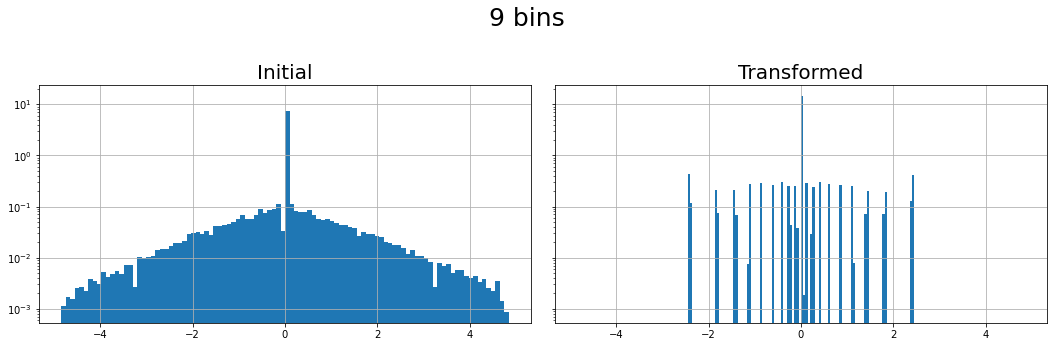

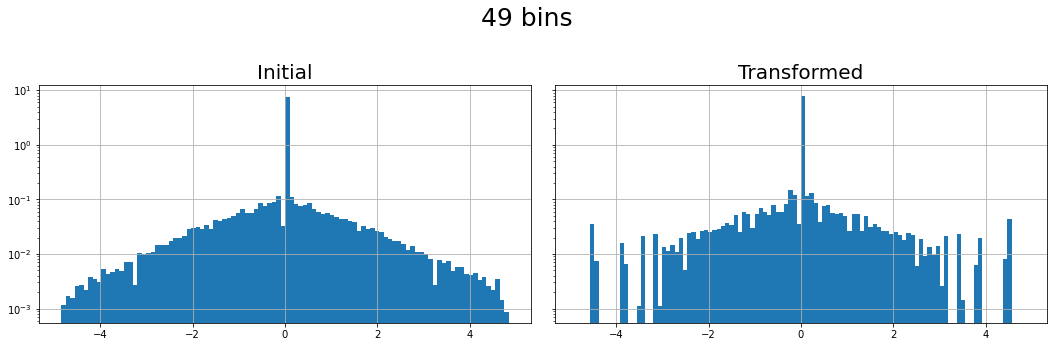

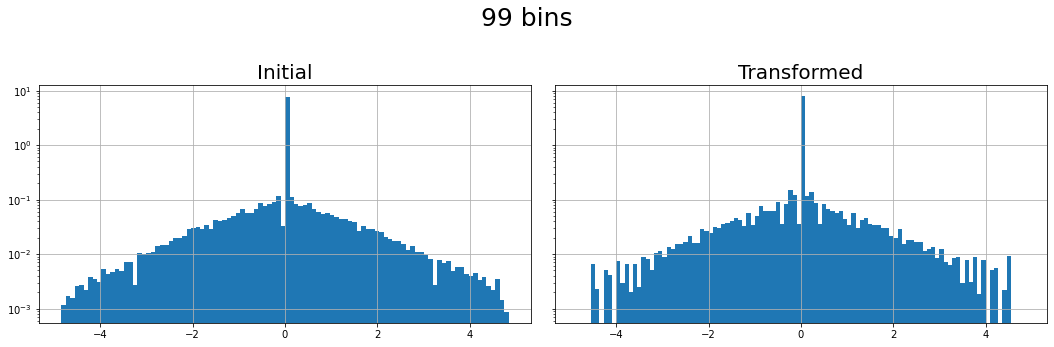

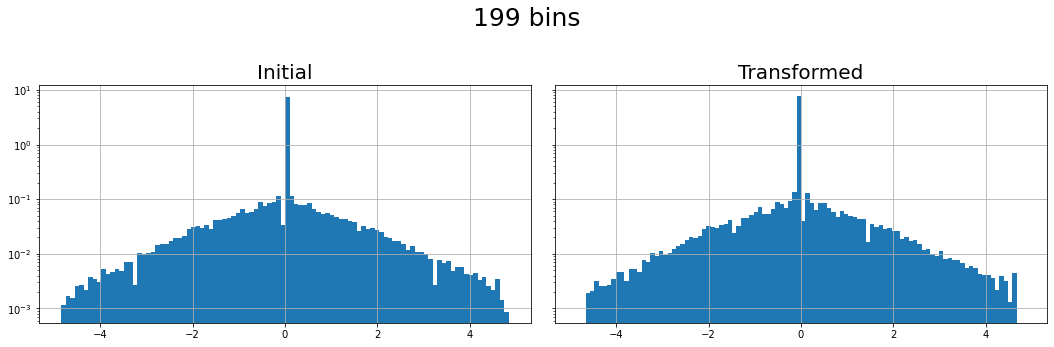

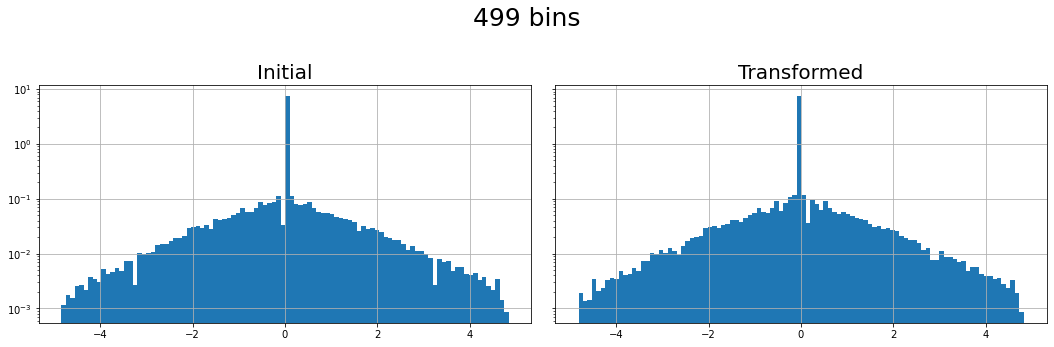

In [14]:
dm_rel = np.round_(dm / h) * h / mid_price[:-1]
lim = np.quantile(np.abs(dm_rel), 0.995)
for n_bins in [10, 50, 100, 200, 500]:
    dm_encoder = MidPriceEncoder(n_bins=n_bins, tick_size=1e-7)
    dm_encoder.fit(dm_rel)
    dm_pr = dm_encoder.predict(dm_rel)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle(f"{dm_encoder.k_dm} bins", fontsize=25)
    ax[1].hist( (mid_price[:-1] * dm_pr)[(-lim <= dm_pr) & (dm_pr <= lim) ], bins=hist_bins, density=True, log=log)
    ax[1].grid(True)
    ax[1].set_title("Transformed", fontsize=20)

    ax[0].hist( (mid_price[:-1] * dm_rel)[(-lim <= dm_rel) &(dm_rel <= lim) ], bins=hist_bins, density=True, log=log)
    ax[0].grid(True)
    ax[0].set_title("Initial", fontsize=20)
    plt.tight_layout(pad=2)
plt.show()

## 100 бинов ок

In [29]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb       = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

In [30]:
#model parameters:
#number of unique imbalances
n = 6
#max quantile to use for spread encoding
max_quantile = 0.99
max_steps    = 3
step_inc     = 8
#tick size
tick_size = 0.1

n_bins = 200

h = 0.01

spread_encoder = UniformSpreadEncoder(tick_size, max_quantile=0.999, n_bins1 = 3, n_bins2 = 10)
dummy_dm_encoder = DummyMidPriceEncoder()
dummy_encoder = Encoder(n, spread_encoder, dummy_dm_encoder)
dummy_pricer = DummyMicroPrice(dummy_encoder)

spread_encoder = UniformSpreadEncoder(tick_size, max_quantile=0.999, n_bins1 = 3, n_bins2 = 10)
dm_encoder = MidPriceEncoder(n_bins=n_bins, tick_size=1e-7)
encoder = Encoder(n, spread_encoder, dm_encoder)
micro_pricer = SimpleMicroPrice(encoder)

In [31]:
dm_rel = np.round_(dm / h) * h / mid_price[:-1]

In [32]:
micro_pricer.fit(imb, spread, dm_rel)
dummy_pricer.fit(imb, spread, dm_rel)

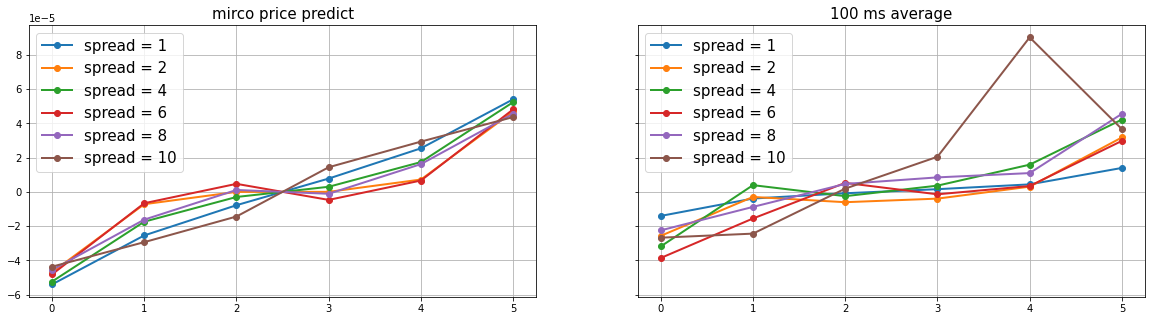

In [33]:
imbalances = micro_pricer.encoder.imb_set 
fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
for s in dummy_pricer.encoder.spread_set[:6]:
    y = micro_pricer.G[s]
    z = dummy_pricer.G[s]
    ax[0].plot(imbalances, y, '-o', label=f'spread = {s}', linewidth=2)
    ax[1].plot(imbalances, z, '-o', label=f'spread = {s}', linewidth=2)
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[0].set_title("mirco price predict", fontsize=15)
ax[1].set_title("100 ms average", fontsize=15)
plt.show()

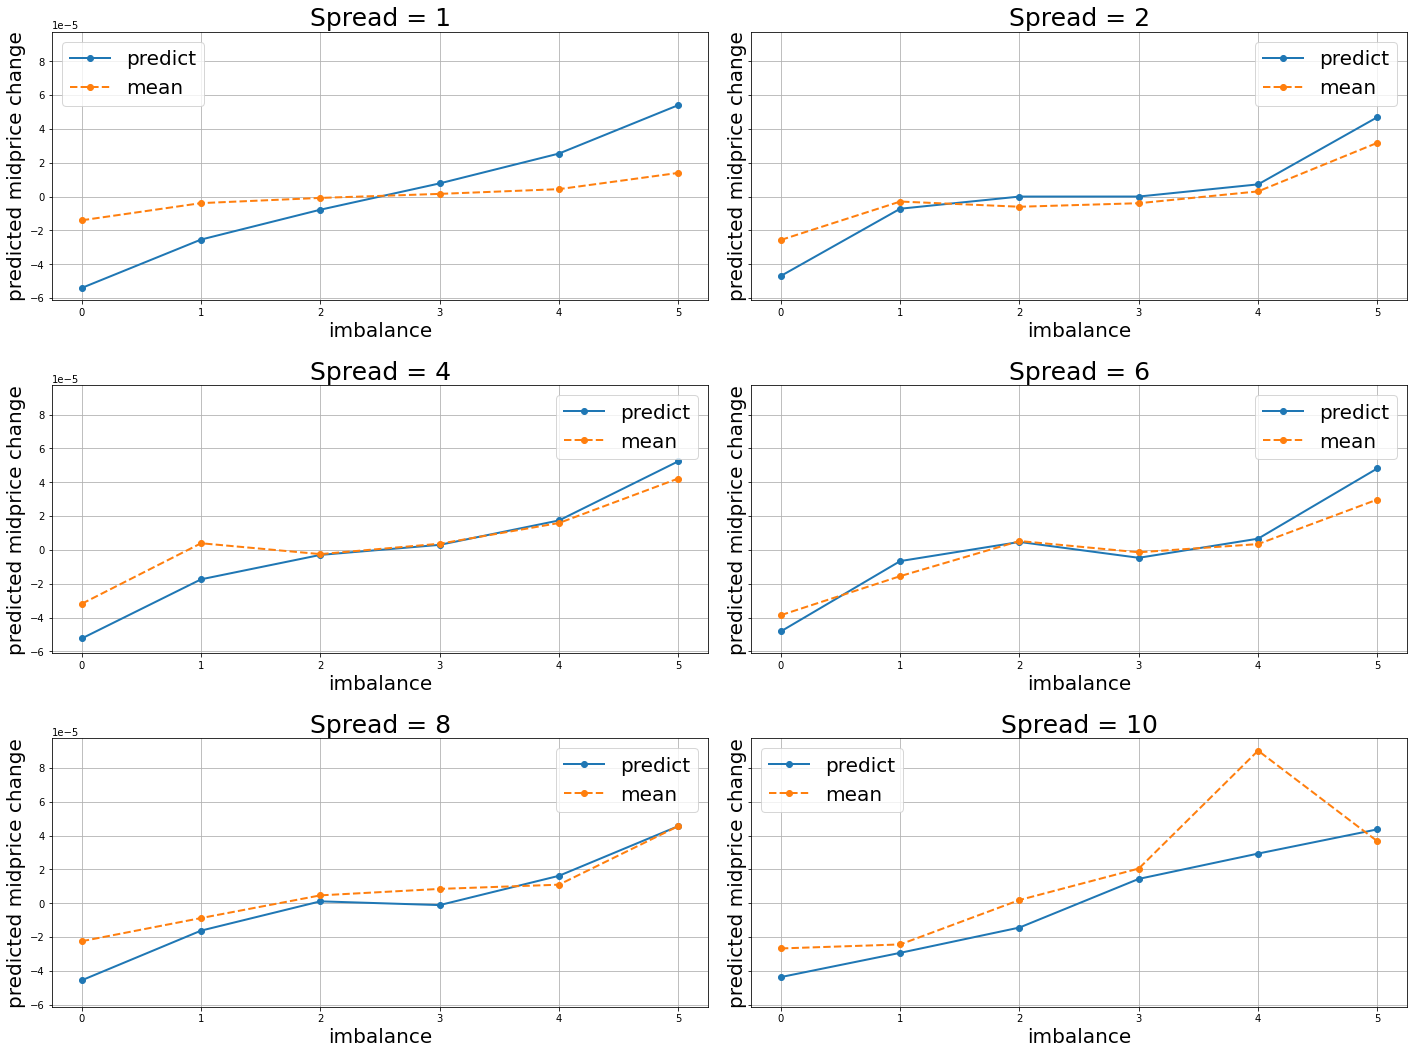

In [34]:
imbalances = micro_pricer.encoder.imb_set 

fig, ax = plt.subplots(3, 2, figsize=(20, 15), sharey=True)
ax = ax.reshape(-1)
i = 0

G_mean = dummy_pricer.apply(np.mean)
G_med  = dummy_pricer.apply(np.median)
G_std  = dummy_pricer.apply(np.std)

for s in dummy_pricer.encoder.spread_set[:6]:
    y = micro_pricer.G[s]
    ax[i].plot(imbalances, y, '-o', label='predict', linewidth=2)
    ax[i].plot(imbalances, G_mean[s], '--o',label='mean', linewidth=2)
    ax[i].grid(True)
    ax[i].set_title(f"Spread = {s}", fontsize=25)
    ax[i].legend(fontsize=20)
    ax[i].set_xlabel("imbalance", fontsize=20)
    ax[i].set_ylabel('predicted midprice change', fontsize=20)
    i += 1
plt.tight_layout(pad=2)
plt.show()

In [35]:
G_mean = {}

for n_ticks in [1, 2, 5, 10]:
    
    dummy_dm_encoder = DummyMidPriceEncoder()
    dummy_encoder = Encoder(n, spread_encoder, dummy_dm_encoder)
    dummy_pricer = DummyMicroPrice(dummy_encoder)
    dm_rel_ = np.round_( (mid_price[n_ticks:]-mid_price[:-n_ticks]) / h ) * h / mid_price[:-n_ticks]
    dummy_pricer.fit(imb, spread, dm_rel_)
    G_mean[n_ticks] = dummy_pricer.apply(np.mean)

Spread = 1
Delay = 100 ms, 	err = 0.0001357652
Delay = 200 ms, 	err = 0.0001103807
Delay = 500 ms, 	err = 0.0000782023
Delay = 1000 ms, 	err = 0.0000604802
-------------------------------------------
Spread = 2
Delay = 100 ms, 	err = 0.0000547706
Delay = 200 ms, 	err = 0.0000332980
Delay = 500 ms, 	err = 0.0000535325
Delay = 1000 ms, 	err = 0.0000922900
-------------------------------------------
Spread = 4
Delay = 100 ms, 	err = 0.0000546375
Delay = 200 ms, 	err = 0.0000629292
Delay = 500 ms, 	err = 0.0001045235
Delay = 1000 ms, 	err = 0.0001435366
-------------------------------------------
Spread = 6
Delay = 100 ms, 	err = 0.0000438996
Delay = 200 ms, 	err = 0.0000404239
Delay = 500 ms, 	err = 0.0000930628
Delay = 1000 ms, 	err = 0.0001415164
-------------------------------------------
Spread = 8
Delay = 100 ms, 	err = 0.0000488537
Delay = 200 ms, 	err = 0.0000794802
Delay = 500 ms, 	err = 0.0001104790
Delay = 1000 ms, 	err = 0.0002210482
-------------------------------------------


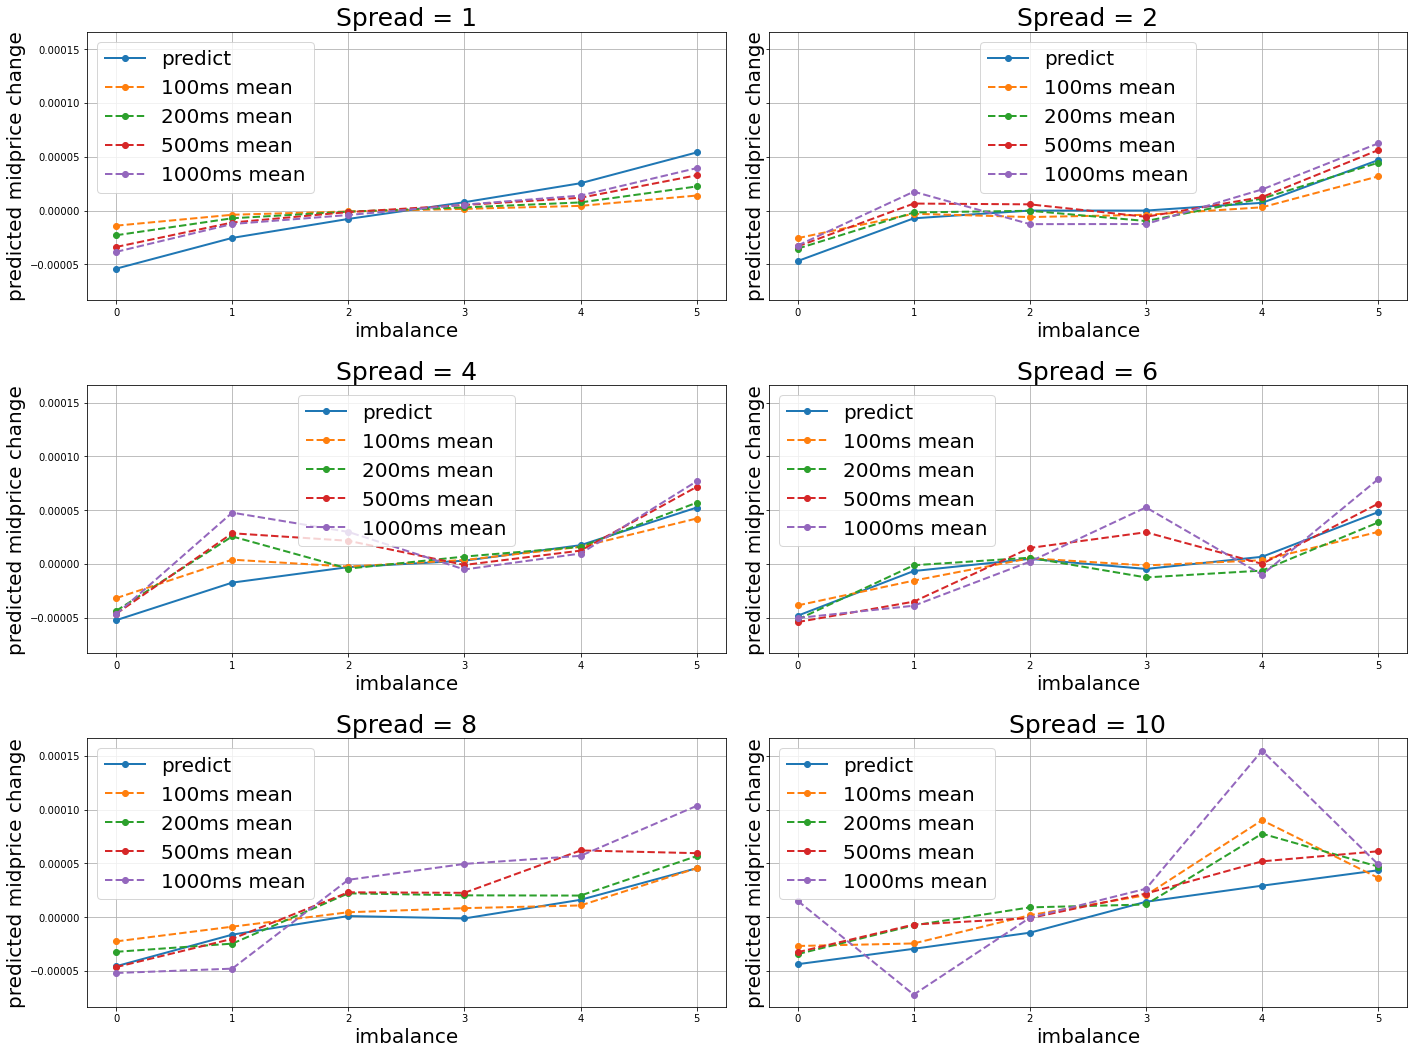

In [36]:
imbalances = micro_pricer.encoder.imb_set 

fig, ax = plt.subplots(3, 2, figsize=(20, 15), sharey=True)
ax = ax.reshape(-1)
i = 0

for s in dummy_pricer.encoder.spread_set[:6]:
    y = micro_pricer.G[s]
    ax[i].plot(imbalances, y, '-o', label='predict', linewidth=2)
    print(f"Spread = {s}")
    for n_ticks in G_mean.keys():
        ax[i].plot(imbalances, G_mean[n_ticks][s], '--o', label=f'{n_ticks * 100}ms mean', linewidth=2)
        err = np.sum( np.abs( G_mean[n_ticks][s] - y ) )
        print(f"Delay = {n_ticks * 100} ms, \terr = {err:0.10f}")
    print('-------------------------------------------')
    ax[i].grid(True)
    ax[i].set_title(f"Spread = {s}", fontsize=25)
    ax[i].legend(fontsize=20)
    ax[i].set_xlabel("imbalance", fontsize=20)
    ax[i].set_ylabel('predicted midprice change', fontsize=20)
    i += 1
plt.tight_layout(pad=2)
plt.show()

In [37]:
n_layers = 5

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb       = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

In [38]:
#model parameters:
#number of unique imbalances
n = 6
#max quantile to use for spread encoding
max_quantile = 0.99
max_steps    = 3
step_inc     = 8
#tick size
tick_size = 0.1

n_bins = 200

h = 0.01

spread_encoder = UniformSpreadEncoder(tick_size, max_quantile=0.999, n_bins1 = 3, n_bins2 = 10)
dummy_dm_encoder = DummyMidPriceEncoder()
dummy_encoder = Encoder(n, spread_encoder, dummy_dm_encoder)
dummy_pricer = DummyMicroPrice(dummy_encoder)

spread_encoder = UniformSpreadEncoder(tick_size, max_quantile=0.999, n_bins1 = 3, n_bins2 = 10)
dm_encoder = MidPriceEncoder(n_bins=n_bins, tick_size=1e-7)
encoder = Encoder(n, spread_encoder, dm_encoder)
micro_pricer = SimpleMicroPrice(encoder)

In [39]:
dm_rel = np.round_(dm / h) * h / mid_price[:-1]

In [40]:
micro_pricer.fit(imb, spread, dm_rel)
dummy_pricer.fit(imb, spread, dm_rel)

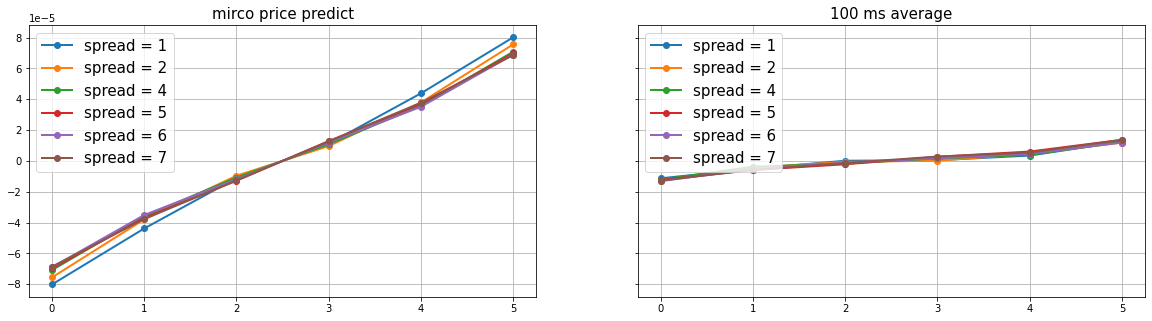

In [41]:
imbalances = micro_pricer.encoder.imb_set 
fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
for s in dummy_pricer.encoder.spread_set[:6]:
    y = micro_pricer.G[s]
    z = dummy_pricer.G[s]
    ax[0].plot(imbalances, y, '-o', label=f'spread = {s}', linewidth=2)
    ax[1].plot(imbalances, z, '-o', label=f'spread = {s}', linewidth=2)
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[0].set_title("mirco price predict", fontsize=15)
ax[1].set_title("100 ms average", fontsize=15)
plt.show()

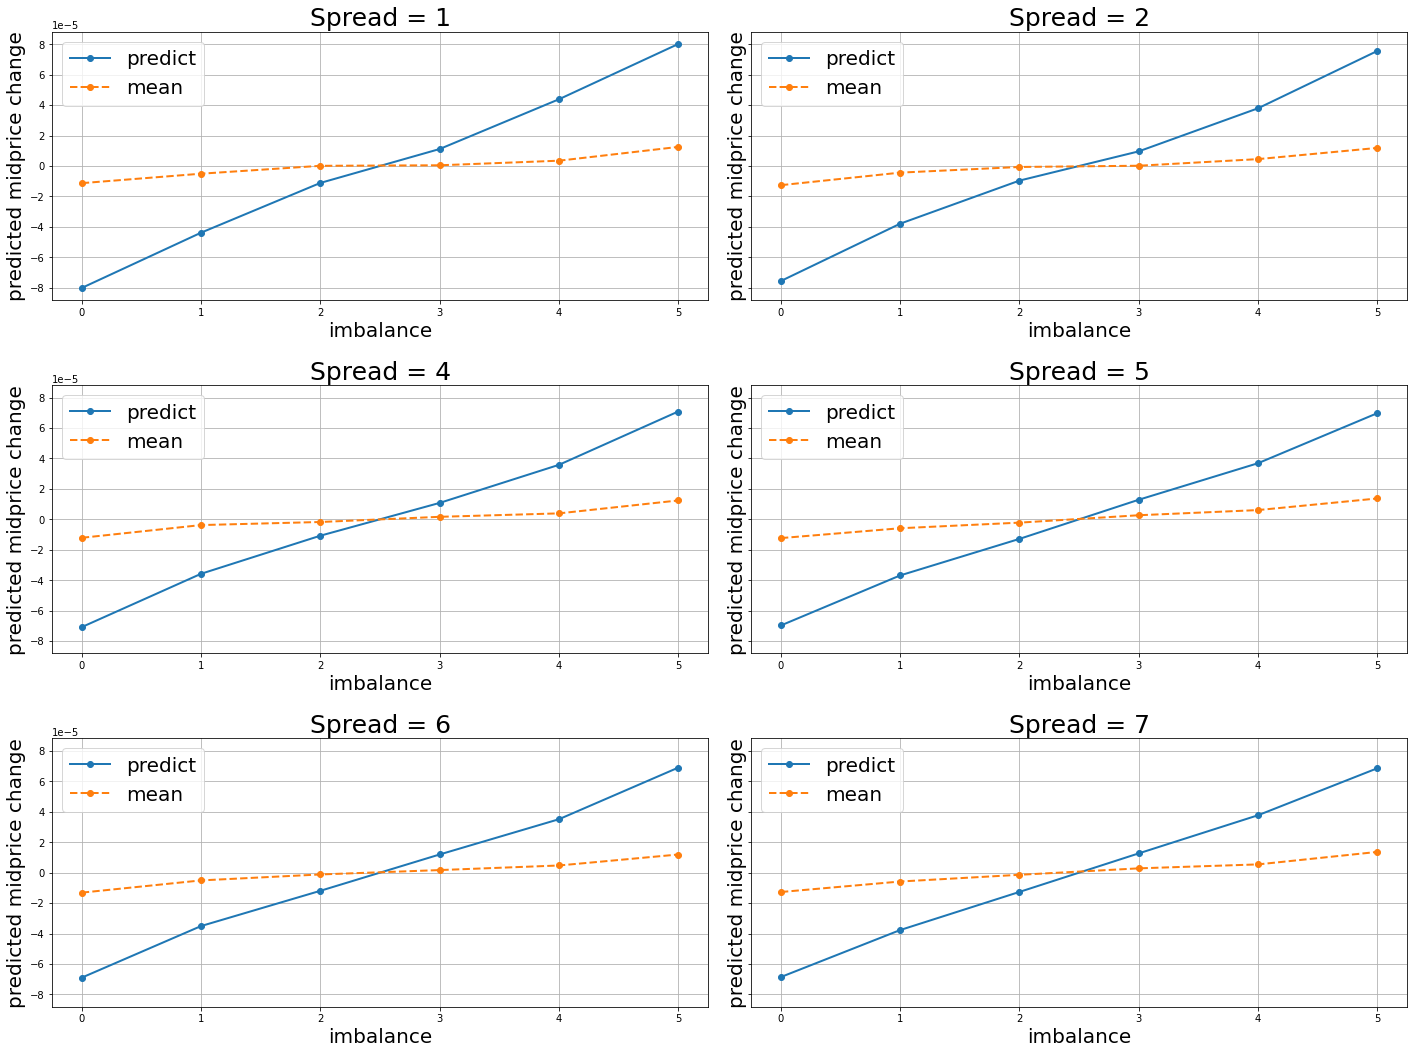

In [42]:
imbalances = micro_pricer.encoder.imb_set 

fig, ax = plt.subplots(3, 2, figsize=(20, 15), sharey=True)
ax = ax.reshape(-1)
i = 0

G_mean = dummy_pricer.apply(np.mean)
G_med  = dummy_pricer.apply(np.median)
G_std  = dummy_pricer.apply(np.std)

for s in dummy_pricer.encoder.spread_set[:6]:
    y = micro_pricer.G[s]
    ax[i].plot(imbalances, y, '-o', label='predict', linewidth=2)
    ax[i].plot(imbalances, G_mean[s], '--o',label='mean', linewidth=2)
    ax[i].grid(True)
    ax[i].set_title(f"Spread = {s}", fontsize=25)
    ax[i].legend(fontsize=20)
    ax[i].set_xlabel("imbalance", fontsize=20)
    ax[i].set_ylabel('predicted midprice change', fontsize=20)
    i += 1
plt.tight_layout(pad=2)
plt.show()

In [45]:
G_mean = {}

for n_ticks in [1, 2, 5, 15, 50]:
    
    dummy_dm_encoder = DummyMidPriceEncoder()
    dummy_encoder = Encoder(n, spread_encoder, dummy_dm_encoder)
    dummy_pricer = DummyMicroPrice(dummy_encoder)
    dm_rel_ = np.round_( (mid_price[n_ticks:]-mid_price[:-n_ticks]) / h ) * h / mid_price[:-n_ticks]
    dummy_pricer.fit(imb, spread, dm_rel_)
    G_mean[n_ticks] = dummy_pricer.apply(np.mean)

Spread = 1
Delay = 100 ms, 	err = 0.0002374591
Delay = 200 ms, 	err = 0.0002122512
Delay = 500 ms, 	err = 0.0001949397
Delay = 1500 ms, 	err = 0.0001402090
Delay = 5000 ms, 	err = 0.0001806359
-------------------------------------------
Spread = 2
Delay = 100 ms, 	err = 0.0002119942
Delay = 200 ms, 	err = 0.0001858893
Delay = 500 ms, 	err = 0.0001447532
Delay = 1500 ms, 	err = 0.0001042849
Delay = 5000 ms, 	err = 0.0000581860
-------------------------------------------
Spread = 4
Delay = 100 ms, 	err = 0.0001991339
Delay = 200 ms, 	err = 0.0001766473
Delay = 500 ms, 	err = 0.0001414362
Delay = 1500 ms, 	err = 0.0000883213
Delay = 5000 ms, 	err = 0.0000699843
-------------------------------------------
Spread = 5
Delay = 100 ms, 	err = 0.0001960670
Delay = 200 ms, 	err = 0.0001731482
Delay = 500 ms, 	err = 0.0001443894
Delay = 1500 ms, 	err = 0.0001186830
Delay = 5000 ms, 	err = 0.0001001123
-------------------------------------------
Spread = 6
Delay = 100 ms, 	err = 0.0001942721
Delay

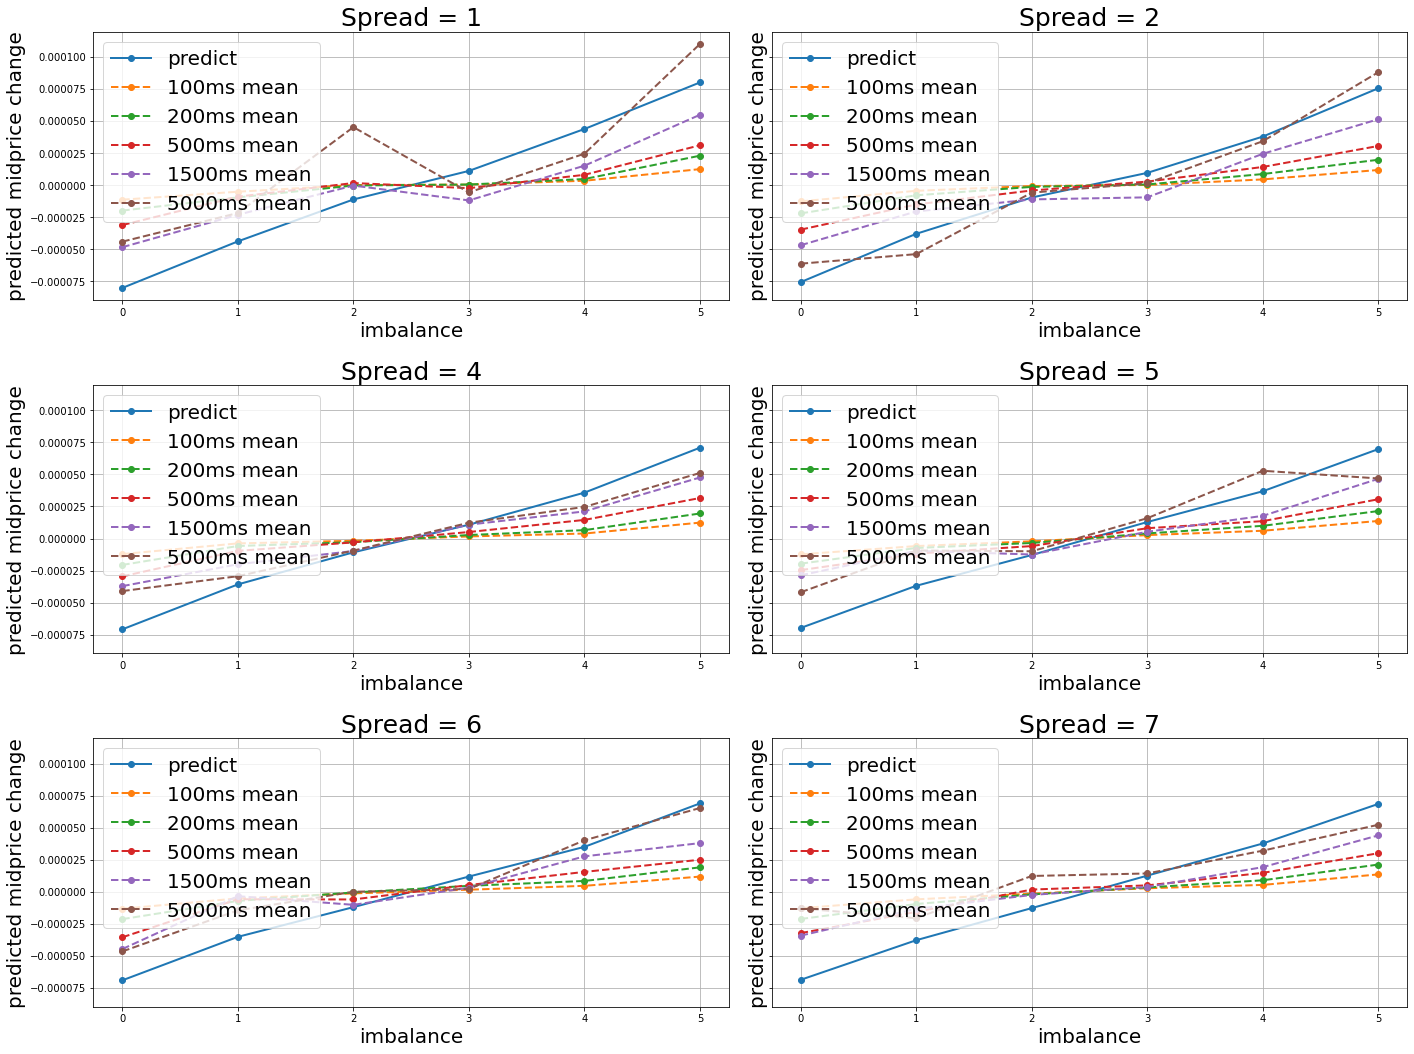

In [46]:
imbalances = micro_pricer.encoder.imb_set 

fig, ax = plt.subplots(3, 2, figsize=(20, 15), sharey=True)
ax = ax.reshape(-1)
i = 0

for s in dummy_pricer.encoder.spread_set[:6]:
    y = micro_pricer.G[s]
    ax[i].plot(imbalances, y, '-o', label='predict', linewidth=2)
    print(f"Spread = {s}")
    for n_ticks in G_mean.keys():
        ax[i].plot(imbalances, G_mean[n_ticks][s], '--o', label=f'{n_ticks * 100}ms mean', linewidth=2)
        err = np.sum( np.abs( G_mean[n_ticks][s] - y ) )
        print(f"Delay = {n_ticks * 100} ms, \terr = {err:0.10f}")
    print('-------------------------------------------')
    ax[i].grid(True)
    ax[i].set_title(f"Spread = {s}", fontsize=25)
    ax[i].legend(fontsize=20)
    ax[i].set_xlabel("imbalance", fontsize=20)
    ax[i].set_ylabel('predicted midprice change', fontsize=20)
    i += 1
plt.tight_layout(pad=2)
plt.show()

In [60]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb       = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

#model parameters:
#number of unique imbalances
n = 6
#max quantile to use for spread encoding
max_quantile = 0.99
max_steps    = 3
step_inc     = 8
#tick size
tick_size = 0.1

n_bins = 200

h = 0.01

spread_encoder = UniformSpreadEncoder(tick_size, max_quantile=0.999, n_bins1 = 3, n_bins2 = 10)
dummy_dm_encoder = DummyMidPriceEncoder()
dummy_encoder = Encoder(n, spread_encoder, dummy_dm_encoder)
dummy_pricer = DummyMicroPrice(dummy_encoder)

spread_encoder = UniformSpreadEncoder(tick_size, max_quantile=0.999, n_bins1 = 3, n_bins2 = 10)
dm_encoder = MidPriceEncoder(n_bins=n_bins, tick_size=1e-7)
encoder = Encoder(n, spread_encoder, dm_encoder)
micro_pricer = SimpleMicroPrice(encoder)

abs_micro_pricer = SimpleMicroPrice(Encoder(n, spread_encoder, MidPriceEncoder()))
abs_micro_pricer.fit(imb, spread, dm)
abs_micro_price = mid_price + abs_micro_pricer.predict(imb, spread)

dm_rel = np.round_(dm / h) * h / mid_price[:-1]

dummy_pricer.fit(imb, spread, dm_rel)
micro_pricer.fit(imb, spread, dm_rel)

#dummy micro price
dummy_price = mid_price * (1 + dummy_pricer.predict(imb, spread))

micro_price = mid_price * (1 + micro_pricer.predict(imb, spread))

idx = slice(None, 10000, 1)

dt = lobs.index

path = '../results/relative_price/'

df_mid = pd.DataFrame( {"micro price":micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )
fig = px.line(df_mid)
fig.write_html(path + "mid_micro_price_1_layer.html")

df_mid = pd.DataFrame( {"relative micro price":micro_price[idx], "absolute micro price":abs_micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )
fig = px.line(df_mid)
fig.write_html(path + "abs_rel_mid_micro_price_1_layer.html")

df_bidask = pd.DataFrame( {"micro price":micro_price[idx], "ask price":ask_price[idx], "bid price":bid_price[idx]}, index=dt[idx] )
fig = px.line(df_bidask)
fig.write_html(path + "bid_ask_micro_price_1_layer.html")

df_mid = pd.DataFrame( {"micro price":micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )
fig = px.line(df_mid)
fig.write_html(path + "mid_dummy_micro_price_1_layer.html")

df_bidask = pd.DataFrame( {"micro price":micro_price[idx], "ask price":ask_price[idx], "bid price":bid_price[idx]}, index=dt[idx] )
fig = px.line(df_bidask)
fig.write_html(path + "bid_ask_dummy_micro_price_1_layer.html")

In [61]:
n_layers = 3

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb       = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

#model parameters:
#number of unique imbalances
n = 6
#max quantile to use for spread encoding
max_quantile = 0.99
max_steps    = 3
step_inc     = 8
#tick size
tick_size = 0.1

n_bins = 200

h = 0.01

spread_encoder = UniformSpreadEncoder(tick_size, max_quantile=0.999, n_bins1 = 3, n_bins2 = 10)
dummy_dm_encoder = DummyMidPriceEncoder()
dummy_encoder = Encoder(n, spread_encoder, dummy_dm_encoder)
dummy_pricer = DummyMicroPrice(dummy_encoder)

spread_encoder = UniformSpreadEncoder(tick_size, max_quantile=0.999, n_bins1 = 3, n_bins2 = 10)
dm_encoder = MidPriceEncoder(n_bins=n_bins, tick_size=1e-7)
encoder = Encoder(n, spread_encoder, dm_encoder)
micro_pricer = SimpleMicroPrice(encoder)

abs_micro_pricer = SimpleMicroPrice(Encoder(n, spread_encoder, MidPriceEncoder()))
abs_micro_pricer.fit(imb, spread, dm)
abs_micro_price = mid_price + abs_micro_pricer.predict(imb, spread)

dm_rel = np.round_(dm / h) * h / mid_price[:-1]

dummy_pricer.fit(imb, spread, dm_rel)
micro_pricer.fit(imb, spread, dm_rel)

#dummy micro price
dummy_price = mid_price * (1 + dummy_pricer.predict(imb, spread))

micro_price = mid_price * (1 + micro_pricer.predict(imb, spread))

idx = slice(None, 10000, 1)

dt = lobs.index

path = '../results/relative_price/'

df_mid = pd.DataFrame( {"micro price":micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )
fig = px.line(df_mid)
fig.write_html(path + "mid_micro_price_3_layer.html")

df_mid = pd.DataFrame( {"relative micro price":micro_price[idx], "absolute micro price":abs_micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )
fig = px.line(df_mid)
fig.write_html(path + "abs_rel_mid_micro_price_3_layer.html")

df_bidask = pd.DataFrame( {"micro price":micro_price[idx], "ask price":ask_price[idx], "bid price":bid_price[idx]}, index=dt[idx] )
fig = px.line(df_bidask)
fig.write_html(path + "bid_ask_micro_price_3_layer.html")

df_mid = pd.DataFrame( {"micro price":micro_price[idx], "mid price":mid_price[idx]}, index=dt[idx] )
fig = px.line(df_mid)
fig.write_html(path + "mid_dummy_micro_price_3_layer.html")

df_bidask = pd.DataFrame( {"micro price":micro_price[idx], "ask price":ask_price[idx], "bid price":bid_price[idx]}, index=dt[idx] )
fig = px.line(df_bidask)
fig.write_html(path + "bid_ask_dummy_micro_price_3_layer.html")